# DPC Location-Allocation Model

### Problem Definition

This script implements the model for locating Detection and Prevention Centers (DPCs) as described in Section 4.3.2 of the paper "A survey of healthcare facility location" by Ahmadi-Javid et al.

> **Given**:
> * A set of client locations, each with a known population (`wi`).
> * A set of candidate locations for opening DPCs.
> * A policy decision on the total number of DPCs to open (`p`).
> * A viability threshold specifying the minimum number of clients an open DPC must serve (`Wmin`).

> **Objective**:
> To find the optimal locations for the `p` DPCs and the corresponding allocation of clients to them, such that the **total expected number of participating clients is maximized**.

**Unique Characteristics**:

The model incorporates two key features of DPCs:
1.  **Viability Threshold**: Each opened DPC must attract a minimum number of clients (`Wmin`) to be considered operational.
2.  **Elastic Demand**: Client participation is not guaranteed. It is modeled as a function of distance; the further a client is from a DPC, the lower their expected participation (`σij`).

---

### Mathematical Formulation

#### Variables

$$
x_j = \begin{cases}
1 & \text{if a DPC is opened at candidate location } j \\
0 & \text{otherwise}
\end{cases}
$$

$$
y_{ij} = \begin{cases}
1 & \text{if client point } i \text{ is assigned to a DPC at location } j \\
0 & \text{otherwise}
\end{cases}
$$

#### Model

$$
\begin{align}
\max \quad & \sum_{i \in I} \sum_{j \in J} \sigma_{ij} y_{ij} \\
\text{s.t.} \quad & \\
& \sum_{j \in J} x_j = p \\
& \sum_{j \in J} y_{ij} \le 1, \quad \forall i \in I \\
& \sum_{i \in I} \sigma_{ij} y_{ij} \ge W_{\min} x_j, \quad \forall j \in J \\
& y_{ij} \le x_j, \quad \forall i \in I, j \in J \\
& x_j \in \{0, 1\}, \quad y_{ij} \in \{0, 1\}
\end{align}
$$


## Setup

In [4]:
# ## 1. Setup and Imports
import networkx as nx
# import gurobipy as gb
import matplotlib.pyplot as plt
import math

class args:
    figsize = (12, 12)

In [5]:
# ## 2. Drawing Functions
def DrawInitG(client_nodes, candidate_nodes, G):
    """Draws the initial problem setup."""
    plt.figure(figsize=args.figsize)
    pos = {i: (G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    # Draw client nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=client_nodes.keys(),
                           node_shape='s',  # Square for clients
                           node_size=500,
                           node_color='skyblue',
                           label="Client Locations")
    
    # Draw candidate DPC locations
    nx.draw_networkx_nodes(G, pos,
                           nodelist=candidate_nodes.keys(),
                           node_shape='o',  # Circle for candidates
                           node_size=500,
                           node_color='lightgreen',
                           label="Candidate DPC Locations")

    nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)
    plt.title("Initial Problem Setup")
    plt.axis('off')
    plt.show()

def DrawSol(client_nodes, candidate_nodes, G, x, y):
    """Draws the solution."""
    plt.figure(figsize=args.figsize)
    pos = {i: (G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    # Get the list of open DPCs from the solution
    open_dpcs = [j for j in candidate_nodes if x[j].x > 0.9]
    
    # Draw client nodes
    nx.draw_networkx_nodes(G, pos,
                           nodelist=client_nodes.keys(),
                           node_shape='s',
                           node_size=500,
                           node_color='skyblue')

    # Draw all candidate DPC locations (closed ones are light)
    nx.draw_networkx_nodes(G, pos,
                           nodelist=candidate_nodes.keys(),
                           node_shape='o',
                           node_size=500,
                           node_color='lightgray')
    
    # Highlight the open DPCs
    nx.draw_networkx_nodes(G, pos,
                           nodelist=open_dpcs,
                           node_shape='o',
                           node_size=800, # Make them bigger
                           node_color='green',
                           edgecolors='black')

    # Draw assignment edges
    assignment_edges = []
    for i in client_nodes:
        for j in candidate_nodes:
            if y[i, j].x > 0.9:
                assignment_edges.append((i, j))
    
    nx.draw_networkx_edges(G, pos,
                           edgelist=assignment_edges,
                           edge_color='gray',
                           style='dashed')
    
    nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)
    plt.title("Optimal DPC Locations and Client Assignments")
    plt.axis('off')
    plt.show()

## Data generation (Toy model)

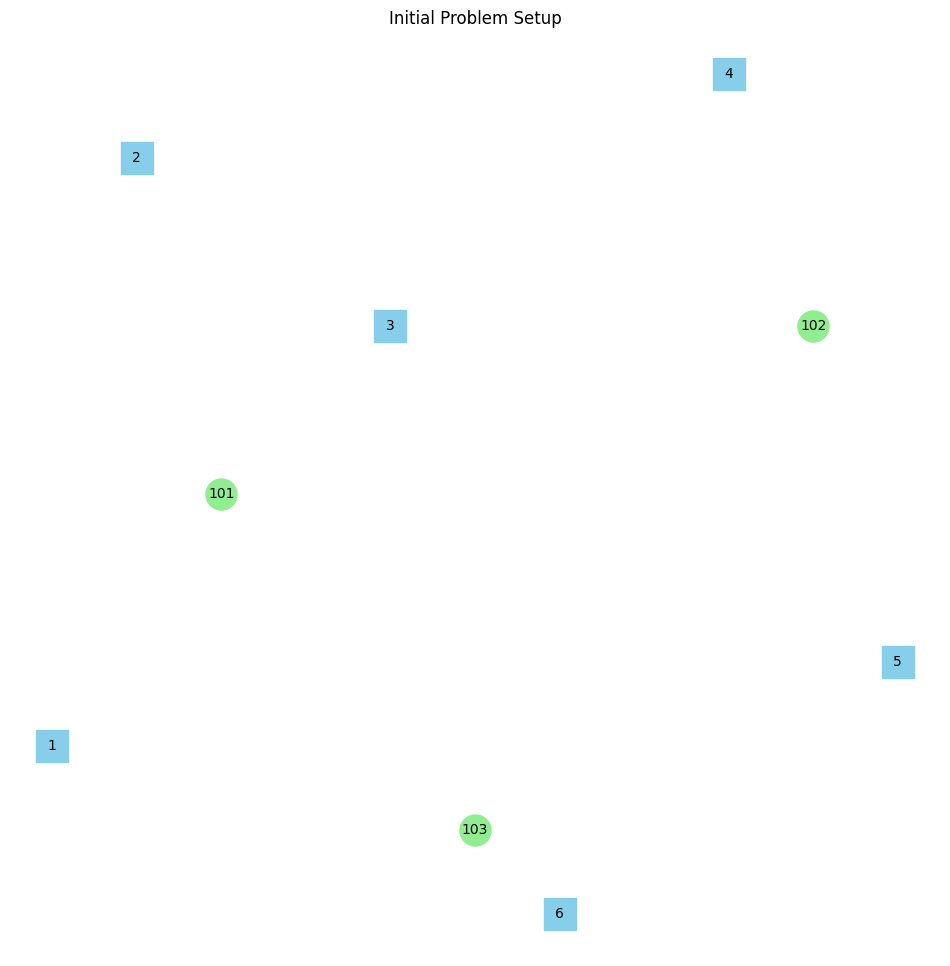

In [6]:
# Create a toy problem instance.

# We will represent all locations (clients and candidates) in a single graph.
# Node attributes will distinguish them.
G = nx.Graph()

# Define client locations with their coordinates and populations
client_nodes = {
    1: {'x': 10, 'y': 20, 'pop': 1500},
    2: {'x': 15, 'y': 55, 'pop': 800},
    3: {'x': 30, 'y': 45, 'pop': 2200},
    4: {'x': 50, 'y': 60, 'pop': 1200},
    5: {'x': 60, 'y': 25, 'pop': 3100},
    6: {'x': 40, 'y': 10, 'pop': 900},
}

# Define candidate DPC locations with their coordinates
candidate_nodes = {
    101: {'x': 20, 'y': 35},
    102: {'x': 55, 'y': 45},
    103: {'x': 35, 'y': 15},
}

# Add nodes to the graph
for node, attr in client_nodes.items():
    G.add_node(node, **attr, type='client')
for node, attr in candidate_nodes.items():
    G.add_node(node, **attr, type='candidate')

# Visualize the initial setup
DrawInitG(client_nodes, candidate_nodes, G)

## Model Parameters definition

In [8]:
# Policy parameters
p = 2      # Number of DPCs to open
Wmin = 2000 # Minimum required clients for a DPC to be viable

# Elastic demand parameter
max_dist = 40 # Maximum distance a client is willing to travel

In [9]:
# Pre-calculate Elastic Demand (σij)
# Function to calculate Euclidean distance
def euclidean_dist(p1, p2):
    return math.sqrt((p1['x'] - p2['x'])**2 + (p1['y'] - p2['y'])**2)

# Calculate sigma values based on a linear decay function
sigma = {}
for i, i_attr in client_nodes.items():
    for j, j_attr in candidate_nodes.items():
        dist = euclidean_dist(i_attr, j_attr)
        if dist <= max_dist:
            # Participation decreases linearly with distance
            participation_rate = 1.0 - (dist / max_dist)
            sigma[i, j] = i_attr['pop'] * participation_rate
        else:
            sigma[i, j] = 0

sigma

{(1, 101): 823.959135850502,
 (1, 102): 0,
 (1, 103): 543.933841201353,
 (2, 101): 387.68943743823394,
 (2, 102): 0,
 (2, 103): 0,
 (3, 101): 1422.1825406947978,
 (3, 102): 825.0,
 (3, 103): 527.2403041679894,
 (4, 101): 28.462548614001904,
 (4, 102): 725.6583509747431,
 (4, 103): 0,
 (5, 101): 0,
 (5, 102): 1502.2965700731565,
 (5, 103): 1013.2486372353798,
 (6, 101): 179.64852328880454,
 (6, 102): 43.225525590310276,
 (6, 103): 740.9009742330268}

## Gurobi model definiton

In [11]:
dpc_model = gb.Model("DPC_Location_Model")

#  Define Decision Variables

# x_j = 1 if DPC is opened at location j
x = dpc_model.addVars(candidate_nodes.keys(), vtype=gb.GRB.BINARY, name="x")

# y_ij = 1 if client i is assigned to DPC j
y = dpc_model.addVars(sigma.keys(), vtype=gb.GRB.BINARY, name="y")

# ---
# ### 4.5. Set Objective Function
# ---

dpc_model.setObjective(y.prod(sigma), sense=gb.GRB.MAXIMIZE)

dpc_model.update()
dpc_model.write('dpc_model.lp')

NameError: name 'gb' is not defined

In [12]:
# Add Constraints

# Constraint (51): Open exactly p DPCs
dpc_model.addConstr(x.sum() == p, name="num_dpcs")

# Constraint (52): Each client is assigned to at most one DPC
dpc_model.addConstrs((y.sum(i, '*') <= 1 for i in client_nodes.keys()), name="assign_client")

# Constraint (54): Clients can only be assigned to open DPCs (linking constraint)
dpc_model.addConstrs((y[i, j] <= x[j] for i, j in sigma.keys()), name="link_y_x")

# Constraint (53): Each open DPC must meet the minimum client threshold
dpc_model.addConstrs(
    (gb.quicksum(sigma[i, j] * y[i, j] for i in client_nodes.keys()) >= Wmin * x[j]
     for j in candidate_nodes.keys()), name="viability")

dpc_model.update()
dpc_model.write('dpc_model.lp') # Save the model formulation for inspection

NameError: name 'dpc_model' is not defined

In [13]:
# Solve the Model and Display Results
dpc_model.optimize()

NameError: name 'dpc_model' is not defined

In [14]:
# Print and Visualize Solution

if dpc_model.status == gb.GRB.OPTIMAL:
    print(f"\nOptimal Objective (Total Expected Clients): {dpc_model.objVal:.2f}\n")
    
    print("Optimal DPC Locations:")
    for j in candidate_nodes:
        if x[j].x > 0.5:
            print(f" -> DPC at location {j} is OPENED.")
            
    print("\nClient Assignments:")
    for i in client_nodes:
        for j in candidate_nodes:
            if y[i, j].x > 0.5:
                print(f" -> Client {i} is assigned to DPC {j}.")
                
    # Draw the solution graph
    DrawSol(client_nodes, candidate_nodes, G, x, y)
    
elif dpc_model.status == gb.GRB.INFEASIBLE:
    print("The model is infeasible. This could be because the viability constraint (Wmin) is too high or the number of DPCs (p) is too low.")
else:
    print(f"Optimization finished with status: {dpc_model.status}")

NameError: name 'dpc_model' is not defined